## Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
from utils.plot_util import *
import socket
import os
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

# set up gpu to make sure one gpu can work for multiple scripts at the same time
os.environ["CUDA_VISIBLE_DEVICES"]="0" # use the first gpu
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [4]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

file: V27-100bar_LEM1

ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>

Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>

Points:
(419301,)

shift_opts_freqs_all:
(121, 419301)



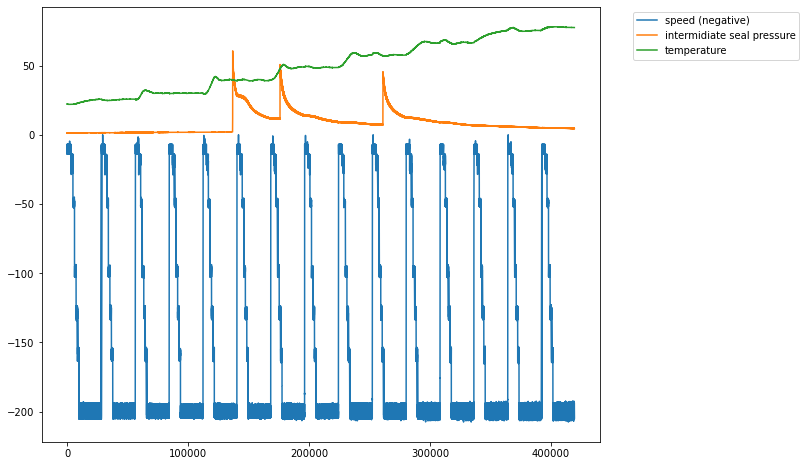

In [5]:
num = 1  # TODO 
file = file_list_LEM1[num]
filename = file.split(os.sep)[-1][:-3]
pklName = DIR + '/data/V27/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")
print("file:",filename)
print("\nATTR:")
print(h51.attrs.keys())
print("\nKeys:")
print(h51.keys())
print("\nPoints:")
print(h51['t'].shape)
print("\nshift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)
print()

#     # print look up dictionary
#     json_object = json.loads(h51.attrs["name_lookup"])
#     json_formatted_str = json.dumps(json_object, indent=2)
#     print("\nLOOKUP:")
#     print(json_formatted_str)

# plot of speed, isp and temperature
fidx = 20
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(h51['spd1'],label='speed (negative)')
plt.plot(h51['ip1k1'],label='intermidiate seal pressure')
plt.plot(h51['k1t'],label='temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



In [6]:
# set up model saving folder
if num == 0:
    SAVED_IN = DIR + "/models/V27/100bar/"
if num == 1:
    SAVED_IN = DIR + "/models/V27/200bar/"
if num == 2:
    SAVED_IN = DIR + "/models/V27/30bar/"
    
SAVED_IN = os.path.abspath(SAVED_IN)
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)


In [7]:
N = 100 # ignore first N points
s21 = np.array(h51['S21_P1_LEM1'])
dataset = []
for j in range (121):
    index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
    dataset.append(s21[index,j].real)
    dataset.append(s21[index,j].imag)
    
X = np.asarray(dataset).T
y = np.asarray(h51['ip1k1'][N:])
print("X:")
print(X.shape)
print("y:")
print(y.shape)

X:
(419201, 242)
y:
(419201,)


In [8]:
h51.close()

## Preprocessing

In [9]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

# indices2 = np.arange(X_train.shape[0])
# X_train2, X_val, y_train2, y_val, idx_train2, idx_val = train_test_split(X_train, y_train, indices2, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_train.shape)
print(X_test.shape)

(335360, 242)
(83841, 242)


## Hyperparameter fine-tuning

In [10]:
# def baseline_model():
#   model = keras.Sequential([
#       layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
#       layers.Dense(64, kernel_initializer='normal',activation='relu'),
#       layers.Dense(1)
#   ])

#   model.compile(loss='mean_squared_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))
#   return model

In [11]:
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold

# # evaluate model
# estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=64, verbose=0)
# kfold = KFold(n_splits=3)
# results = cross_val_score(estimator, X_val_scaled, y_val, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (abs(results.mean()), results.std()))

## Training of ip1k1

### Baseline model with normalization

In [12]:
MODEL_NAME = "NN_baseline"

In [13]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [14]:
def baseline_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [15]:
NN_baseline = baseline_model(normalizer)
NN_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,910
Trainable params: 39,425
Non-trainable params: 485
_________________________________________________________________


In [16]:
%%time
history = NN_baseline.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Epoch 1/100
4192/4192 - 6s - loss: 20.2556 - val_loss: 17.8310
Epoch 2/100
4192/4192 - 5s - loss: 16.8950 - val_loss: 17.0014
Epoch 3/100
4192/4192 - 5s - loss: 15.5595 - val_loss: 15.0309
Epoch 4/100
4192/4192 - 5s - loss: 14.4286 - val_loss: 14.3036
Epoch 5/100
4192/4192 - 5s - loss: 13.3685 - val_loss: 13.2509
Epoch 6/100
4192/4192 - 5s - loss: 12.5682 - val_loss: 12.8574
Epoch 7/100
4192/4192 - 5s - loss: 11.8375 - val_loss: 12.3212
Epoch 8/100
4192/4192 - 5s - loss: 11.2808 - val_loss: 11.5921
Epoch 9/100
4192/4192 - 5s - loss: 10.7251 - val_loss: 10.7685
Epoch 10/100
4192/4192 - 5s - loss: 10.2453 - val_loss: 10.8125
Epoch 11/100
4192/4192 - 5s - loss: 9.8367 - val_loss: 10.5152
Epoch 12/100
4192/4192 - 5s - loss: 9.4647 - val_loss: 10.1125
Epoch 13/100
4192/4192 - 5s - loss: 9.0773 - val_loss: 9.9493
Epoch 14/100
4192/4192 - 5s - loss: 8.8098 - val_loss: 9.3486
Epoch 15/100
4192/4192 - 5s - loss: 8.5015 - val_loss: 9.2079
Epoch 16/100
4192/4192 - 5s - loss: 8.3113 - val_loss: 8.

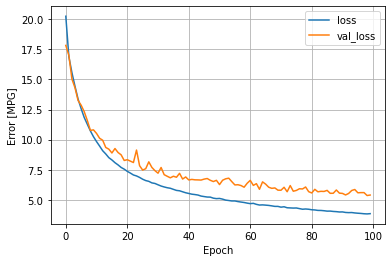

In [17]:
plot_loss(history)

In [18]:
NN_baseline.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\100barNN_baseline\assets


In [19]:
# MODEL_NAME = "NN_baseline"
# NN_baseline = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [20]:
# Collect the results on the test set
NN_baseline.evaluate(X_test, y_test,verbose = 2)

2621/2621 - 3s - loss: 5.3723


5.372323036193848

In [21]:
# X_ = scaler.fit_transform(X)
y_ = NN_baseline.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [22]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  3.9754384
MSE of the prediction on test set:  5.372326


No handles with labels found to put in legend.
C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\scripts\training\V27\utils\plot_util.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


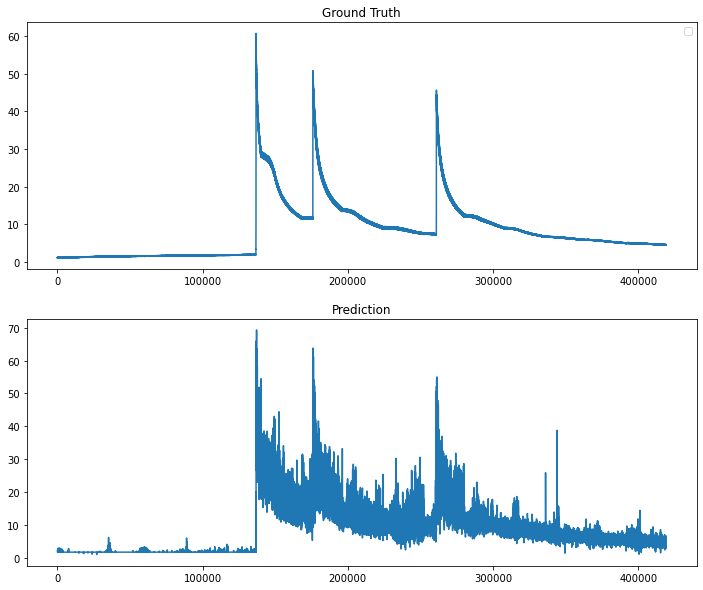

In [23]:
# predictioin vs ground truth
%matplotlib inline
plot_gt_pre(y,y_)

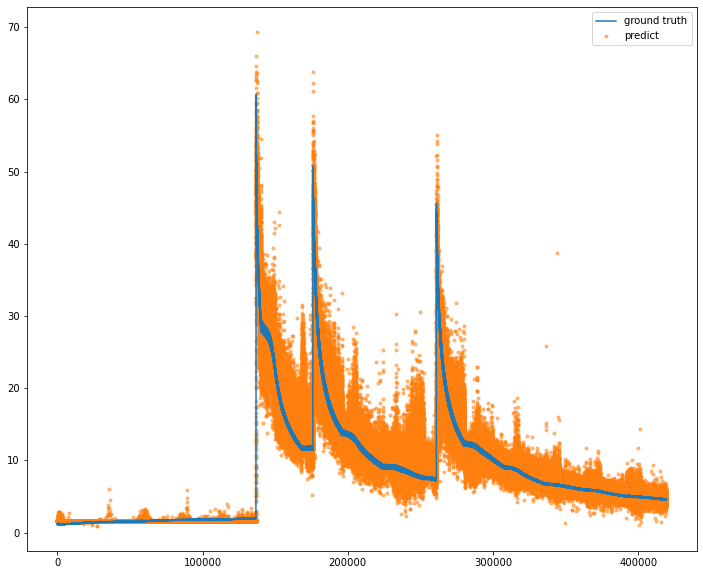

In [24]:
# predictioin vs ground truth in one plot
%matplotlib inline
plot_gt_pre_overlap(y,y_)

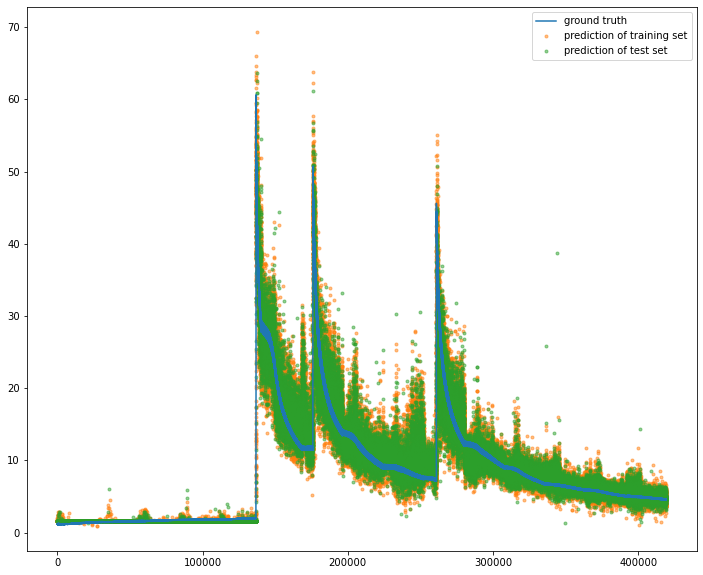

In [25]:
# (predictioin for X_test and X_train separately) vs (ground truth)  in one plot
%matplotlib inline
plot_gt_pre_sep(y,idx_train_sort,y_train_,idx_test_sort,y_test_)

### Model of Previous Project

In [26]:
MODEL_NAME = "NN_pp"

In [27]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [28]:
def model_pp(norm):
  model = keras.Sequential([
      norm,
      # layers.Dense(242, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(100, input_dim=242, kernel_initializer='normal',activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [29]:
NN_pp= model_pp(normalizer)
NN_pp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               24300     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 24,886
Trainable params: 24,401
Non-trainable params: 485
_________________________________________________________________


In [30]:
%%time
history = NN_pp.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 7min 7s


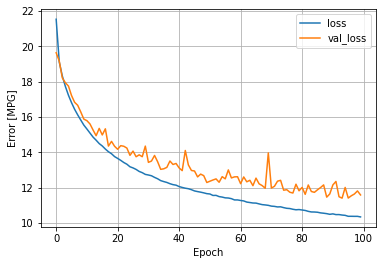

In [31]:
plot_loss(history)

In [32]:
NN_pp.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\100barNN_pp\assets


In [33]:
# MODEL_NAME = "NN_pp"
# NN_pp = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [34]:
# # Collect the results on the test set
# NN_pp.evaluate(X_test, y_test,verbose = 0)

In [35]:
# X_ = scaler.fit_transform(X)
y_ = NN_pp.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [36]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  10.418521
MSE of the prediction on test set:  11.472005


No handles with labels found to put in legend.
C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\scripts\training\V27\utils\plot_util.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


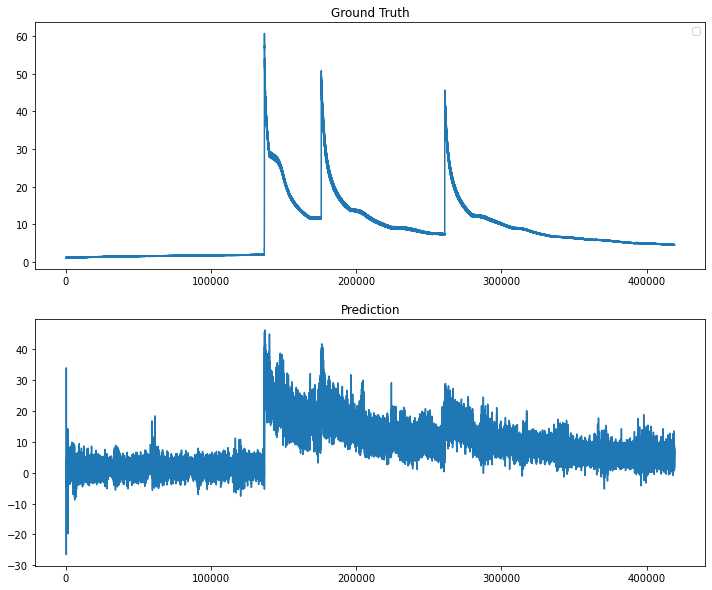

In [37]:
# predictioin vs ground truth
%matplotlib inline
plot_gt_pre(y,y_)

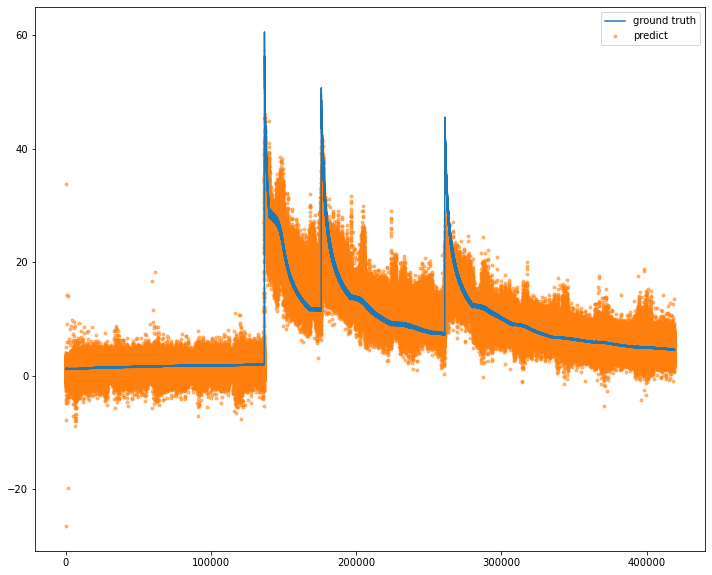

In [38]:
# predictioin vs ground truth in one plot
%matplotlib inline
plot_gt_pre_overlap(y,y_)

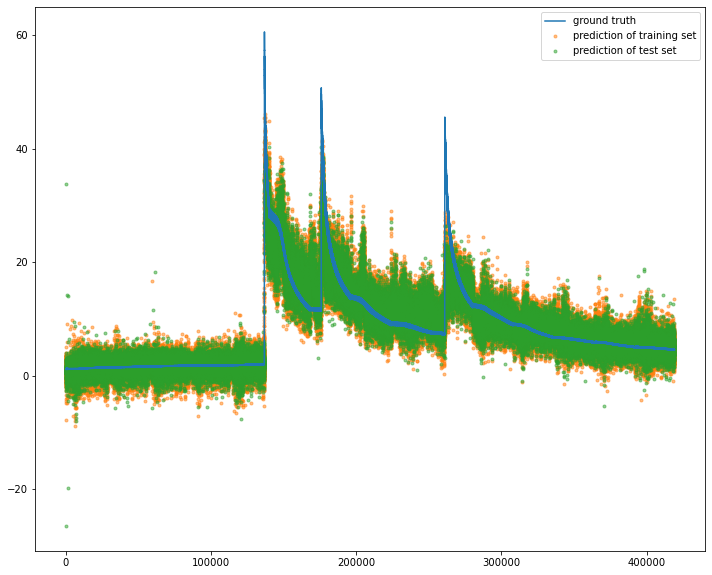

In [39]:
# (predictioin for X_test and X_train separately) vs (ground truth)  in one plot
%matplotlib inline
plot_gt_pre_sep(y,idx_train_sort,y_train_,idx_test_sort,y_test_)

### CNN baseline

Conv1D layer expects input shape in 3D as 

**[batch_size, time_steps, input_dimension]**

However, current data is in the shape of 

**[batch_size, features]**

In [40]:
MODEL_NAME = "CNN_baseline"

In [41]:
# normalisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
scaler.mean_.shape

(242,)

In [42]:
# reshape data
sample_size = X_train_scaled.shape[0] # number of samples in train set
time_steps  = X_train_scaled.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
X_train_reshaped = X_train_scaled.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],time_steps,input_dimension)

In [43]:
n_timesteps = X_train_reshaped.shape[1] # 242
n_features  = X_train_reshaped.shape[2] # 1 
def baseline_cnn_model():
  model = keras.Sequential([
      layers.Input(shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=64, kernel_size=7, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(n_features)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

CNN = baseline_cnn_model()
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 236, 64)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 118, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 114, 32)           10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 57, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 16)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 432)              

In [44]:
%%time
history = CNN.fit(
    X_train_reshaped, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Epoch 1/100
4192/4192 - 14s - loss: 21.9950 - val_loss: 18.9606
Epoch 2/100
4192/4192 - 11s - loss: 17.9576 - val_loss: 17.6002
Epoch 3/100
4192/4192 - 12s - loss: 16.5657 - val_loss: 16.2071
Epoch 4/100
4192/4192 - 12s - loss: 15.5863 - val_loss: 15.7838
Epoch 5/100
4192/4192 - 12s - loss: 14.7636 - val_loss: 16.0125
Epoch 6/100
4192/4192 - 12s - loss: 13.9941 - val_loss: 14.1391
Epoch 7/100
4192/4192 - 11s - loss: 13.3833 - val_loss: 13.6462
Epoch 8/100
4192/4192 - 11s - loss: 12.9248 - val_loss: 13.5499
Epoch 9/100
4192/4192 - 11s - loss: 12.5100 - val_loss: 12.7134
Epoch 10/100
4192/4192 - 11s - loss: 12.1273 - val_loss: 13.1219
Epoch 11/100
4192/4192 - 11s - loss: 11.7688 - val_loss: 12.4628
Epoch 12/100
4192/4192 - 12s - loss: 11.4259 - val_loss: 12.4486
Epoch 13/100
4192/4192 - 12s - loss: 11.1166 - val_loss: 12.2398
Epoch 14/100
4192/4192 - 11s - loss: 10.8630 - val_loss: 11.5846
Epoch 15/100
4192/4192 - 12s - loss: 10.5633 - val_loss: 11.9471
Epoch 16/100
4192/4192 - 12s - los

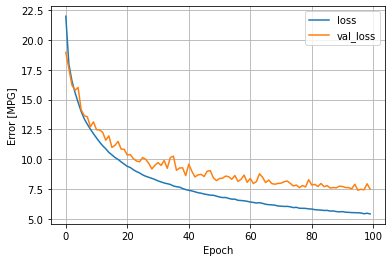

In [45]:
plot_loss(history)

In [46]:
CNN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\100barCNN_baseline\assets


In [47]:
# MODEL_NAME = "CNN_baseline"
# CNN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [48]:
# Collect the results on the test set
CNN.evaluate(X_test_reshaped, y_test,verbose = 2)

2621/2621 - 4s - loss: 7.2317


7.231738567352295

In [49]:
X_ = scaler.transform(X)
X_ = X_.reshape(X_.shape[0],time_steps,input_dimension)
y_ = CNN.predict(X_)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

No handles with labels found to put in legend.
C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\scripts\training\V27\utils\plot_util.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


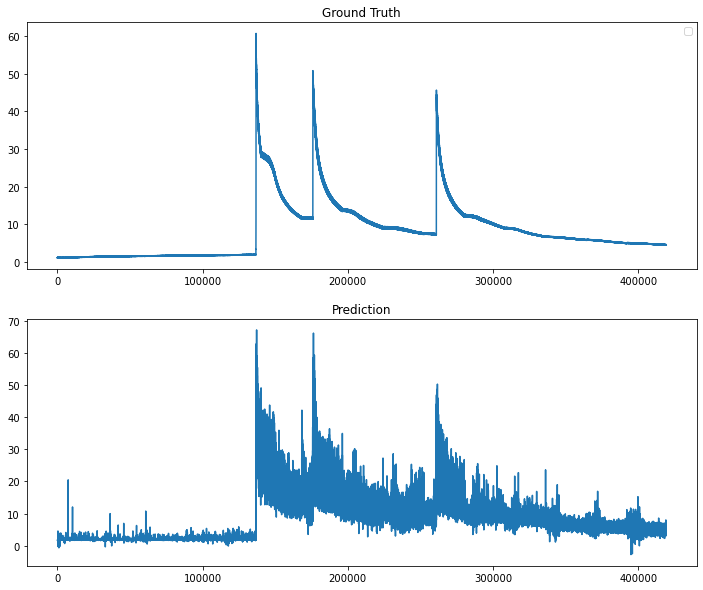

In [50]:
# predictioin vs ground truth
%matplotlib inline
plot_gt_pre(y,y_)

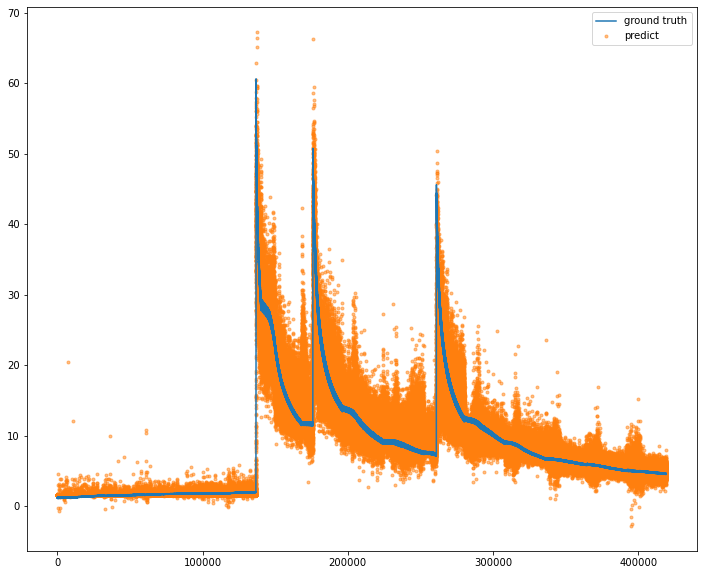

In [51]:
# predictioin vs ground truth in one plot
%matplotlib inline
plot_gt_pre_overlap(y,y_)

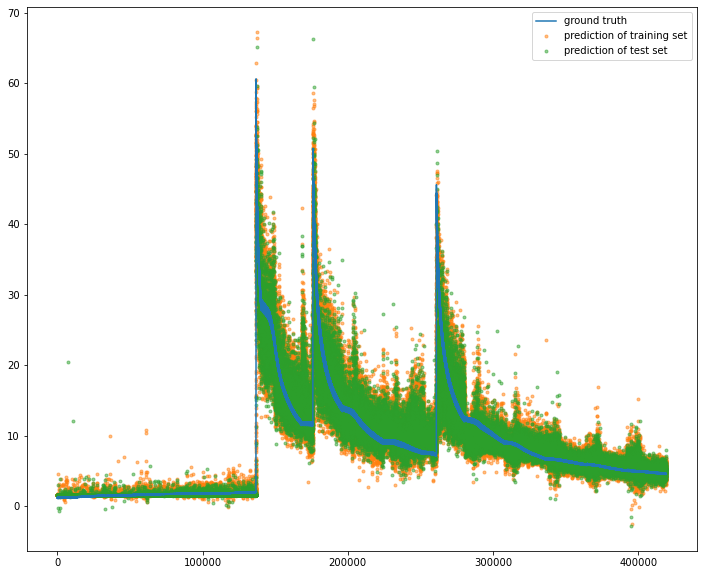

In [52]:
# (predictioin for X_test and X_train separately) vs (ground truth)  in one plot
%matplotlib inline
plot_gt_pre_sep(y,idx_train_sort,y_train_,idx_test_sort,y_test_)

### CNN_tuning

In [53]:
MODEL_NAME = "CNN_tuning"

In [54]:
# normalisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
scaler.mean_.shape

(242,)

In [55]:
# reshape data
sample_size = X_train_scaled.shape[0] # number of samples in train set
time_steps  = X_train_scaled.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
X_train_reshaped = X_train_scaled.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],time_steps,input_dimension)

In [56]:
n_timesteps = X_train_reshaped.shape[1] # 242
n_features  = X_train_reshaped.shape[2] # 1 
def cnn_model():
  model = keras.Sequential([
      layers.Input(shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=64, kernel_size=10, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dense(n_features)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

CNN = cnn_model()
CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 233, 64)           704       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 116, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 114, 32)           6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 57, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 55, 16)            1552      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 27, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 432)              

In [57]:
%%time
history = CNN.fit(
    X_train_reshaped, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Epoch 1/100
4192/4192 - 11s - loss: 22.5398 - val_loss: 20.3473
Epoch 2/100
4192/4192 - 10s - loss: 18.6837 - val_loss: 19.1703
Epoch 3/100
4192/4192 - 10s - loss: 17.4832 - val_loss: 17.8542
Epoch 4/100
4192/4192 - 10s - loss: 16.6385 - val_loss: 16.7240
Epoch 5/100
4192/4192 - 10s - loss: 16.0725 - val_loss: 16.1647
Epoch 6/100
4192/4192 - 10s - loss: 15.5494 - val_loss: 15.5074
Epoch 7/100
4192/4192 - 10s - loss: 15.0960 - val_loss: 16.2634
Epoch 8/100
4192/4192 - 10s - loss: 14.7768 - val_loss: 15.3907
Epoch 9/100
4192/4192 - 10s - loss: 14.4108 - val_loss: 16.4111
Epoch 10/100
4192/4192 - 10s - loss: 14.0980 - val_loss: 14.9549
Epoch 11/100
4192/4192 - 10s - loss: 13.7612 - val_loss: 14.2885
Epoch 12/100
4192/4192 - 10s - loss: 13.5573 - val_loss: 14.9984
Epoch 13/100
4192/4192 - 10s - loss: 13.3052 - val_loss: 13.5871
Epoch 14/100
4192/4192 - 10s - loss: 13.1077 - val_loss: 13.9336
Epoch 15/100
4192/4192 - 10s - loss: 12.8370 - val_loss: 13.2194
Epoch 16/100
4192/4192 - 10s - los

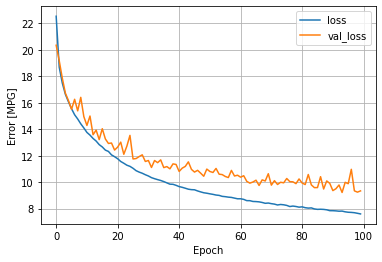

In [58]:
plot_loss(history)

In [59]:
CNN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\100barCNN_tuning\assets


In [60]:
# MODEL_NAME = "CNN_tuning"
# CNN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [61]:
# Collect the results on the test set
CNN.evaluate(X_test_reshaped, y_test,verbose = 2)

2621/2621 - 4s - loss: 9.2519


9.251920700073242

In [62]:
X_ = scaler.transform(X)
X_ = X_.reshape(X_.shape[0],time_steps,input_dimension)
y_ = CNN.predict(X_)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

No handles with labels found to put in legend.
C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\scripts\training\V27\utils\plot_util.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


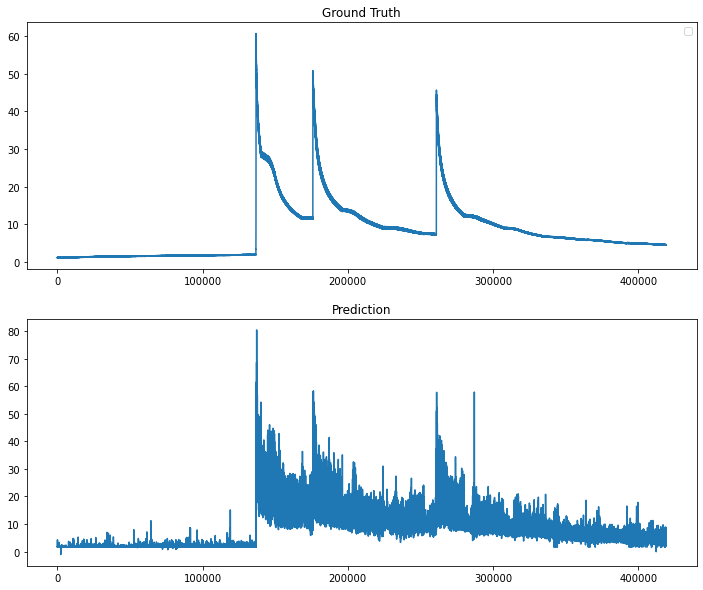

In [63]:
# predictioin vs ground truth
%matplotlib inline
plot_gt_pre(y,y_)

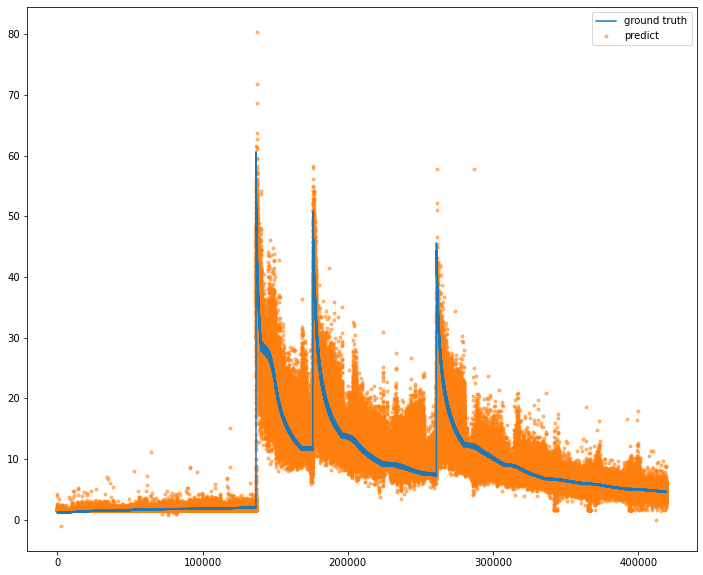

In [64]:
# predictioin vs ground truth in one plot
%matplotlib inline
plot_gt_pre_overlap(y,y_)

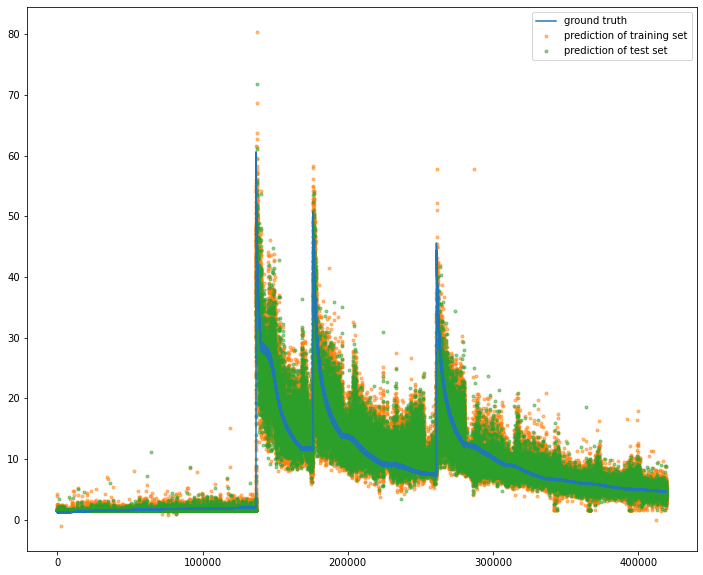

In [65]:
# (predictioin for X_test and X_train separately) vs (ground truth)  in one plot
%matplotlib inline
plot_gt_pre_sep(y,idx_train_sort,y_train_,idx_test_sort,y_test_)